# CS122:  HW 6.1 (Pandas and Case Study)

### (10pt) Q1: plot the treand of temperature changes 

* Repeat the procedue used in lecture "week.14.case.study.ipynb" to produce the result similar to the one shown below.
* Choose the station that is closest to San Jose wtih latitude, longitude = 37.3382, -121.8863 
    * or equivalent (37.3382° N, 121.8863° W)
* Display the trend of the (min,max,min) temperature change from 1893 to 2020
* Fill in your codes in a single cell below.

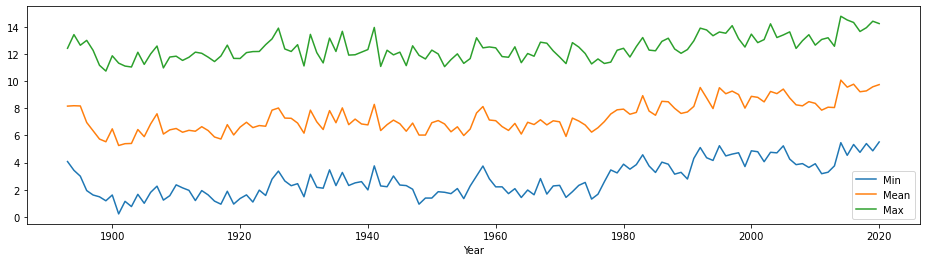

In [1]:
# xxx fill in all pieces of your codes here
import requests

def parse_line(line):
    """ parses line of weather data 
        removes values of -9999 (missing value)
    """
    
    # return None if line is empty
    if not line:
        return None
    
    # split out first 4 fields and string containing temperature values
    record, temperature_string = (line[:11], int(line[11:15]), int(line[15:17]), line[17:21]), line[21:] 
    
    # raise exception if the temperature string is too short
    if len(temperature_string) < 248:
        raise ValueError("String not long enough - {} {}".format(temperature_string, str(line)))
        
    # use a list comprehension on the temperature_string to extract and convert the 
    values = [float(temperature_string[i:i + 5])/10 for i in range(0, 248, 8)
              if not temperature_string[i:i + 5].startswith("-9999")]
    
    # get the number of values, the max and min, and calculate average
    count = len(values)
    tmax = round(max(values), 1)
    tmin = round(min(values), 1)
    mean = round(sum(values)/count, 1)

    # add the temperature summary values to the record fields extracted earlier and return
    return record + (tmax, tmin, mean, count)



# get readme.txt file
s = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt'
r = requests.get(s)
readme = r.text

# get inventory and stations files
s = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt'
r = requests.get(s)
inventory_txt = r.text
s = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
r = requests.get(s)
stations_txt = r.text

# save both the inventory and stations files to disk, in case we need them
f1 = "inventory.txt"
with open(f1, "w") as f:
    f.write(inventory_txt)
    
f2 = "stations.txt"
with open(f2, "w") as f:
    f.write(stations_txt) 
    
# parse to named tuples

# use namedtuple to create a custom Inventory class
from collections import namedtuple
Inventory = namedtuple("Inventory", ['station', 'latitude', 'longitude', 'element', 'start', 'end'])

# parse inventory lines and convert some values to floats and ints
inventory = []
invntry = [x for x in inventory_txt.split("\n") if x.startswith("US")]
for x in invntry:
    a = x[0:11] 
    b = float(x[12:20]) 
    c = float(x[21:30]) 
    d = x[31:35] 
    e = int(x[36:40]) 
    f = int(x[41:45]) 
    y = Inventory(a,b,c,d,e,f)
    inventory.append(y) 

def f(x):
    return x.element in ['TMIN', 'TMAX'] and x.end >= 2015 and x.start < 1920

inventory_temps = [x for x in inventory if f(x) ]

# San Jose
latitude, longitude = 37.3382, -121.8863    #37.3382° N, 121.8863° W
inventory_temps.sort(key=lambda x:  abs(latitude-x.latitude) + abs(longitude-x.longitude))

station_id = 'USC00047916'
# parse stations
Station = namedtuple("Station", ['station_id', 'latitude', 'longitude', 'elevation', 'state', 'name', 'start', 'end'])

stations = [(x[0:11], float(x[12:20]), float(x[21:30]), float(x[31:37]), x[38:40].strip(), x[41:71].strip())
            for x in stations_txt.split("\n") if x.startswith(station_id)]

a = [ x for x in stations_txt.split("\n") if x.startswith(station_id) ]

station = Station(*stations[0] + (inventory_temps[0].start, inventory_temps[0].end))

# fetch daily records for selected station
s = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{}.dly'.format(station.station_id)
r = requests.get(s)
weather = r.text

# save into a text file, so we won't need to fetch again
with open('weather_{}.txt'.format(station), "w") as weather_file:
    weather_file.write(weather)

# read from saved daily file if needed (only used if we want to start the process over without downloadng the file)
with open('weather_{}.txt'.format(station)) as weather_file:
    weather = weather_file.read()

# process all weather data

# list comprehension, will not parse empty lines
weather_data = [parse_line(x) for x in weather.split("\n") if x]
tmax_data = [x for x in weather_data if x[3] == 'TMAX']
tmin_data = [x for x in weather_data if x[3] == 'TMIN']

import pandas as pd
%matplotlib inline

a = ['Station', 'Year', 'Month', 'Element', 'Max', 'Min', 'Mean', 'Days']

tmax_df = pd.DataFrame(tmax_data, columns=a )
tmin_df = pd.DataFrame(tmin_data, columns=a )

# select Year, Min, Max, Mean columns, group by year, average and line plot
a = ['Year','Min', 'Mean', 'Max']
tmin_df[a].groupby('Year').mean().plot( kind='line', figsize=(16, 4))





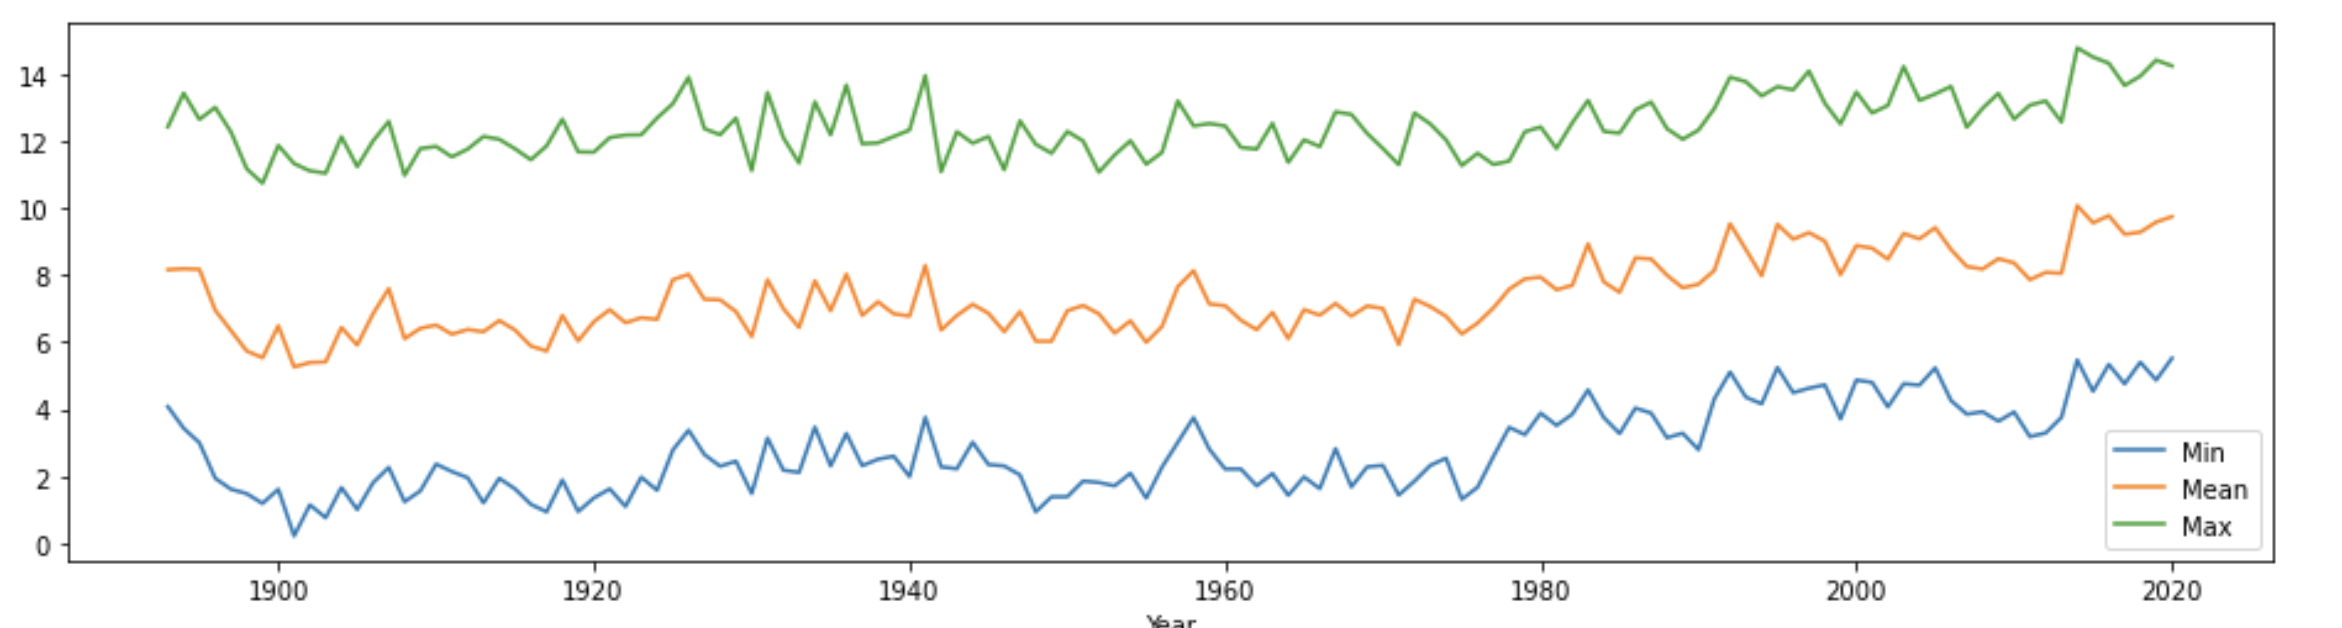

In [2]:
from IPython.display import Image
Image(filename='san.jose.temperature.png')

## Reference for the following questions
* https://www.w3resource.com/python-exercises/pandas/index-dataframe.php

### (6pt) Q2: Write a Pandas program to get the first n rows of a given DataFrame 

* using the following three methods:
    * (2pt) the loc method 
    * (2pt) the iloc  method
    * (2pt) the head method

In [3]:
import pandas as pd
import numpy as np
exam_data  = {'name': ['Anastasia', 'Dima', 'Katherine', 'James', 'Emily', 'Michael', 'Matthew', 'Laura', 'Kevin', 'Jonas'],
        'score': [12.5, 9, 16.5, np.nan, 9, 20, 14.5, np.nan, 8, 19],
        'attempts': [1, 3, 2, 3, 2, 3, 1, 1, 2, 1],
        'qualify': ['yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes']}
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

df = pd.DataFrame(exam_data , index=labels)
n = 3
# xxx print out the first three rows of the data frame using the following three methods

# xxx use df.loc method 
print("\nFirst three rows of the data frame using df.loc:")
print(df.loc['a':'c']) # xxx fill in the missing code here

# xxx use df.iloc  method
print("\nFirst three rows of the data frame using df.iloc:")
print(df.iloc[0:3]) # xxx fill in the missing code here

# xxx use df.head  method
print("\nFirst three rows of the data frame using df.head:")
print(df.head(3)) # xxx fill in the missing code here


First three rows of the data frame using df.loc:
        name  score  attempts qualify
a  Anastasia   12.5         1     yes
b       Dima    9.0         3      no
c  Katherine   16.5         2     yes

First three rows of the data frame using df.iloc:
        name  score  attempts qualify
a  Anastasia   12.5         1     yes
b       Dima    9.0         3      no
c  Katherine   16.5         2     yes

First three rows of the data frame using df.head:
        name  score  attempts qualify
a  Anastasia   12.5         1     yes
b       Dima    9.0         3      no
c  Katherine   16.5         2     yes


### (5pt) Q3: Write a Pandas program to select the specified columns and rows from a given DataFrame.


In [4]:
#
import pandas as pd
import numpy as np

exam_data  = {'name': ['Anastasia', 'Dima', 'Katherine', 'James', 'Emily', 'Michael', 'Matthew', 'Laura', 'Kevin', 'Jonas'],
        'score': [12.5, 9, 16.5, np.nan, 9, 20, 14.5, np.nan, 8, 19],
        'attempts': [1, 3, 2, 3, 2, 3, 1, 1, 2, 1],
        'qualify': ['yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes']}
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

df = pd.DataFrame(exam_data , index=labels)
print (df)

#print("Select specific columns indexed at 1,3,5,6 and rows indexed at 1,3")
a = [1, 3, 5, 6]  # the indices of the selected columns
b = [1,3]         # the indices of the selected rows


# (1pt) use iloc method to print out the same
print(df.iloc[a, b]) # xxx fill in the missing code here

# (4pt) use loc method to print out the same
# xxx fill in the missing code here
rows = [x for i, x in enumerate(df.index) if i in a]
columns = [x for i, x in enumerate(df.columns) if i in b]
print(df.loc[rows][columns])

        name  score  attempts qualify
a  Anastasia   12.5         1     yes
b       Dima    9.0         3      no
c  Katherine   16.5         2     yes
d      James    NaN         3      no
e      Emily    9.0         2      no
f    Michael   20.0         3     yes
g    Matthew   14.5         1     yes
h      Laura    NaN         1      no
i      Kevin    8.0         2      no
j      Jonas   19.0         1     yes
   score qualify
b    9.0      no
d    NaN      no
f   20.0     yes
g   14.5     yes
   score qualify
b    9.0      no
d    NaN      no
f   20.0     yes
g   14.5     yes


### (3pt) Q4: Write a Pandas program to display largest n records within each group of a given DataFramefrom.

In [5]:
import pandas as pd
d = {'col1': [1, 2, 3, 4, 7, 11], 'col2': [4, 5, 6, 9, 5, 0], 'col3': [7, 5, 8, 12, 1,11]}
df = pd.DataFrame(data=d)
#print("Original DataFrame")
#print(df)

n=3
print("\n\nlargest n records within each group of a DataFrame:")
for i in df.columns: #xxx you must use a for-loop to iterate each column of the dataframe as for i in ....
    print(df.nlargest(n, i)) #xxx fill in the missing piece of codes here



largest n records within each group of a DataFrame:
   col1  col2  col3
5    11     0    11
4     7     5     1
3     4     9    12
   col1  col2  col3
3     4     9    12
2     3     6     8
1     2     5     5
   col1  col2  col3
3     4     9    12
5    11     0    11
2     3     6     8


### (3pt) Q5: Write a Pandas program to select rows from a given DataFrame based on values in some columns.


In [6]:
import pandas as pd
import numpy as np
d = {'col1': [1, 4, 3, 4, 5], 'col2': [4, 5, 6, 7, 8], 'col3': [7, 8, 9, 0, 1]}
df = pd.DataFrame(data=d)
#print("Original DataFrame")
#print(df)

for i in df.columns:
    print('\nRows for %s value == 4' % i)
    print(df.loc[df[i] == 4]) # xxx Fill in the missing piece of codes here


Rows for col1 value == 4
   col1  col2  col3
1     4     5     8
3     4     7     0

Rows for col2 value == 4
   col1  col2  col3
0     1     4     7

Rows for col3 value == 4
Empty DataFrame
Columns: [col1, col2, col3]
Index: []


In [7]:
# Expected output
   col1  col2  col3
1     4     5     8
3     4     7     0

Rows for col2 value == 4
   col1  col2  col3
0     1     4     7

Rows for col3 value == 4
Empty DataFrame
Columns: [col1, col2, col3]
Index: []

IndentationError: unexpected indent (<ipython-input-7-05760f2e7a01>, line 2)